<a href="https://colab.research.google.com/github/thdefn/jango/blob/master/prjcervical_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

# 데이터

In [ ]:
root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')


added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')


type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [ ]:
files = {'filepath': type1_files + type2_files + type3_files,
          'label': ['Type 1']* len(type1_files) + ['Type 2']* len(type2_files) + ['Type 3']* len(type3_files)}

files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [ ]:
bad_files = []
for path in tqdm(files_df['filepath'].values):
    try:
        img = Image.open(path)
    except:
        index = files_df[files_df['filepath']==path].index.values[0]
        bad_files.append(index)

100%|██████████| 8215/8215 [01:48<00:00, 75.48it/s]


In [ ]:
bad_files
files_df.drop(bad_files, inplace=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


## **이미지 증식한 데이터 준비**

In [ ]:
# 이미지 증식 부분 batch_size 만큼 이미지를 증가시킴
# train_dir = "../input/intel-mobileodt-cervical-cancer-screening/train/train"
t = ImageDataGenerator(rescale=1./ 255, 
                       rotation_range = 40,
                        zoom_range = 0.2,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        horizontal_flip=True,
                        validation_split=0.2)

t_gen = t.flow_from_dataframe(files_df,x_col='filepath', y_col='label', target_size = (150, 150),batch_size=3,class_mode='categorical', color_mode='rgb', subset='training')
v_gen = t.flow_from_dataframe(files_df,x_col='filepath', y_col='label',target_size = (150, 150),batch_size=1,class_mode='categorical', color_mode='rgb', subset='validation')

Found 6570 validated image filenames belonging to 3 classes.
Found 1642 validated image filenames belonging to 3 classes.


## **이미지 증식 사용 안한 데이터 준비**

In [ ]:
#train_df, valid_df = train_test_split(files_df, test_size = 0.2, stratify = files_df['label'], random_state = 1234)
k = ImageDataGenerator(rescale=1./ 255, validation_split=0.2)
t_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (150, 150), class_mode='categorical', color_mode='rgb', subset='training')
v_nongen = k.flow_from_dataframe(files_df, x_col='filepath', y_col='label', target_size = (150, 150), class_mode='categorical', color_mode='rgb', subset='validation')

Found 6570 validated image filenames belonging to 3 classes.
Found 1642 validated image filenames belonging to 3 classes.


# 원선님 모델

In [ ]:
cnn = Sequential([
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal', input_shape=(150,150,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(32, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
    
])

cnn.summary()

2022-11-18 11:01:23.150114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 11:01:23.152929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 11:01:23.278574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 11:01:23.279416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-18 11:01:23.280209: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
activation (Activation)      (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        18464     
_________________________________________________________________
activation_1 (Activation)    (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 37, 37, 64)        1

In [ ]:
cnn.compile(
    'adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)
verimggen = cnn.fit(t_gen, steps_per_epoch = t_gen.samples//3, validation_data= v_gen, validation_steps= v_gen.samples,epochs= 10, verbose=1)

2022-11-18 11:01:28.134150: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-11-18 11:01:30.688670: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


2190/2190 [==============================] - 1904s 865ms/step - loss: 1.0233 - accuracy: 0.5256 - val_loss: 0.9995 - val_accuracy: 0.5305
Epoch 2/10
2190/2190 [==============================] - 1900s 867ms/step - loss: 1.0101 - accuracy: 0.5288 - val_loss: 1.0001 - val_accuracy: 0.5305
Epoch 3/10
2190/2190 [==============================] - 1906s 870ms/step - loss: 1.0055 - accuracy: 0.5289 - val_loss: 0.9988 - val_accuracy: 0.5305
Epoch 4/10
2190/2190 [==============================] - 1989s 908ms/step - loss: 1.0045 - accuracy: 0.5289 - val_loss: 0.9987 - val_accuracy: 0.5305
Epoch 5/10
2190/2190 [==============================] - 2028s 926ms/step - loss: 1.0044 - accuracy: 0.5289 - val_loss: 0.9989 - val_accuracy: 0.5305
Epoch 6/10
2190/2190 [==============================] - 2120s 968ms/step - loss: 1.0038 - accuracy: 0.5289 - val_loss: 0.9990 - val_accuracy: 0.5305
Epoch 7/10
2190/2190 [==============================] - 2080s 950ms/step - loss: 1.0034 - accuracy: 0.5289 - val_loss

In [ ]:
general = cnn.fit(t_nongen, validation_data= v_nongen, epochs= 10, verbose=1)

Epoch 1/10
206/206 [==============================] - 1945s 9s/step - loss: 1.0034 - accuracy: 0.5289 - val_loss: 0.9990 - val_accuracy: 0.5305
Epoch 2/10
206/206 [==============================] - 1938s 9s/step - loss: 1.0032 - accuracy: 0.5289 - val_loss: 0.9990 - val_accuracy: 0.5305
Epoch 3/10
206/206 [==============================] - 1902s 9s/step - loss: 1.0033 - accuracy: 0.5289 - val_loss: 0.9989 - val_accuracy: 0.5305
Epoch 4/10
206/206 [==============================] - 1942s 9s/step - loss: 1.0031 - accuracy: 0.5289 - val_loss: 0.9989 - val_accuracy: 0.5305
Epoch 5/10
206/206 [==============================] - 1944s 9s/step - loss: 1.0032 - accuracy: 0.5289 - val_loss: 0.9989 - val_accuracy: 0.5305
Epoch 6/10
206/206 [==============================] - 1898s 9s/step - loss: 1.0033 - accuracy: 0.5289 - val_loss: 0.9989 - val_accuracy: 0.5305
Epoch 7/10
206/206 [==============================] - 1974s 10s/step - loss: 1.0031 - accuracy: 0.5289 - val_loss: 0.9988 - val_accuracy

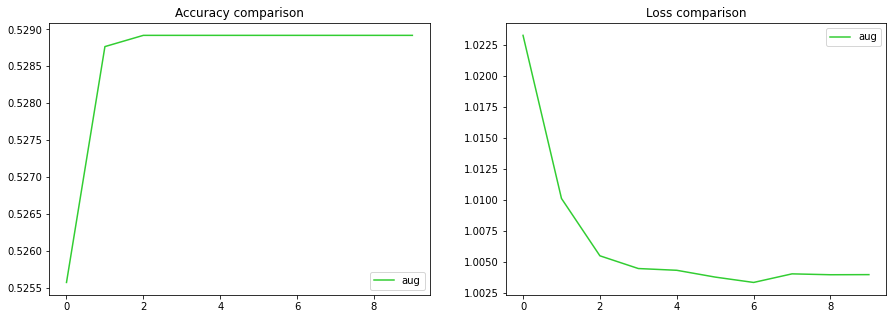

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(verimggen.history['accuracy'], label='aug', color='limegreen')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(verimggen.history['loss'], label='aug', color='limegreen')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()

In [2]:
general = {'loss': [0.9582940340042114,
  0.9375267028808594,
  0.9031842350959778,
  0.8750488758087158,
  0.8442121148109436,
  0.8010153770446777,
  0.7598258852958679,
  0.7030467391014099,
  0.6609349250793457,
  0.6091323494911194],
 'accuracy': [0.5418569445610046,
  0.5462709069252014,
  0.5622526407241821,
  0.5742770433425903,
  0.597564697265625,
  0.6187214851379395,
  0.6403348445892334,
  0.6732115745544434,
  0.6891933083534241,
  0.7135463953018188],
 'val_loss': [0.958389163017273,
  0.9240278601646423,
  0.9280871152877808,
  0.8903028964996338,
  0.8826287984848022,
  0.8894288539886475,
  0.8759817481040955,
  0.8886351585388184,
  0.9607772827148438,
  0.9679125547409058],
 'val_accuracy': [0.5194884538650513,
  0.543848991394043,
  0.5292326211929321,
  0.5548111796379089,
  0.5627284049987793,
  0.5651644468307495,
  0.5706455707550049,
  0.5724725723266602,
  0.5919610261917114,
  0.6053593158721924]}


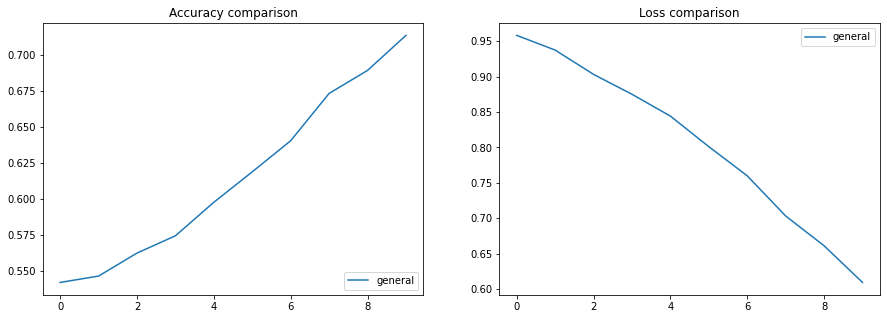

In [3]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(general['accuracy'], label='general')
plt.legend(loc='lower right')
plt.title('Accuracy comparison')

plt.subplot(1, 2, 2)
plt.plot(general['loss'], label='general')
plt.legend(loc='upper right')
plt.title('Loss comparison')

plt.show()